In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import jax.numpy as jnp
import jax
jax.config.update('jax_enable_x64',True)
import triangle
import matplotlib.pyplot as plt
from lm import LM
import scipy as sp
jnp.set_printoptions(precision=4,linewidth=120,suppress=True)


In [4]:
Nside=36
Nsquare=Nside*4
v=np.linspace(0,1,Nside,endpoint=False)
z=np.zeros(Nside)
o=np.ones(Nside)
square=np.c_[np.r_[v,o,1-v,z],np.r_[z,v,o,1-v]]
square_seg = np.c_[np.arange(square.shape[0]-1),np.arange(1,square.shape[0])]
square_seg = np.r_[square_seg,np.array([[square.shape[0]-1,0]])]

Ncircle = 72
r=0.2
w=1.
cx,cy=0.35,0.5
theta = np.linspace(0, 2 * np.pi, Ncircle, endpoint=False)
circle = np.stack([r*np.cos(theta)+cx, r*np.sin(theta)+cy], axis=1)
circle_seg = np.c_[np.arange(circle.shape[0]-1), np.arange(1,circle.shape[0])]
circle_seg = np.r_[circle_seg,np.array([[circle.shape[0]-1,0]])]
circle_seg+=square.shape[0]

square_normals = np.zeros((Nsquare,2))
square_normals[1:Nside] = np.array([0.,1.])
square_normals[Nside+1:2*Nside] = np.array([-1.,0.])
square_normals[2*Nside+1:3*Nside] = np.array([0,-1.])
square_normals[3*Nside+1:4*Nside] = np.array([1.,0.])
a45 = np.sqrt(2)/2
square_normals[0] = np.array([a45, a45])
square_normals[Nside] = np.array([-a45, a45])
square_normals[2*Nside] = np.array([-a45, -a45])
square_normals[3*Nside] = np.array([a45, -a45])

circle_normals = np.c_[np.cos(theta), np.sin(theta)]
normals = np.r_[square_normals, circle_normals]
boundary = np.arange(Nsquare+Ncircle)

In [5]:
A = dict(vertices=np.r_[square,circle], segments=np.r_[square_seg,circle_seg], holes=[[cx, cy]])
B = triangle.triangulate(A, 'qpa0.0005D')

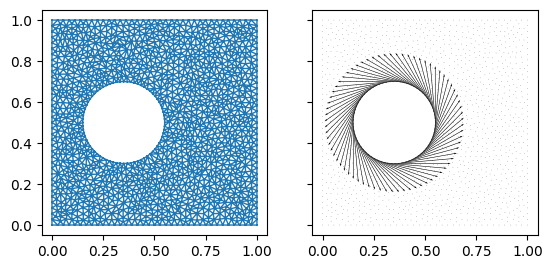

In [6]:
tr=B['triangles']
verts = B['vertices']
interior = np.where(np.ravel(B['vertex_markers'])==0)[0]
unknown=interior
Nunknown=unknown.size
Nverts = verts.shape[0]
u=np.zeros(Nverts)
u[:Nsquare]=0.
u[Nsquare:Nsquare + Ncircle]=-r*w*np.sin(theta)
u[Nsquare+Ncircle:]=0.

v=np.zeros(Nverts)
v[:Nsquare]=0.
v[Nsquare:Nsquare + Ncircle]=r*w*np.cos(theta)
v[Nsquare+Ncircle:]=0.

p=jnp.ones(Nverts)

u=jnp.asarray(u)
v=jnp.asarray(v)
fig1, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].set_aspect('equal')
_=ax[0].triplot(verts[:,0],verts[:,1],'-',triangles=tr,lw=1)
ax[1].set_aspect('equal')
_=ax[1].quiver(verts[:,0],verts[:,1], u, v, scale=0.8)

In [7]:
def get_neighbors(i):
    return np.setdiff1d(np.unique(np.ravel(tr[np.where(tr==i)[0]])),i)

def get_five_neighbors(i):
    nb=get_neighbors(i)
    if nb.size<5:
        for ii in nb:
            nb=np.union1d(nb, get_neighbors(ii))
        nb=np.setdiff1d(nb,i)
    d=np.sum((verts[i]-verts[nb])**2,axis=1)
    if nb.size>5:
        return nb[np.argpartition(d,5)[:5]]
    else:
        return nb

In [8]:
# f = a0*x^2 + a1*y^2 + a2*x + a3*y + a4*xy + f0
# df/dx = 2a0*x + a2 + a4*y
# df/dy = 2a1*y + a3 + a4*x
# df2/dx2 = 2a0
# df2/dy2 = 2a1
# df2/dxdy = a4

def get_LU(i):
    n5 = get_five_neighbors(i)
    x,y = (verts[n5]-verts[i]).T
    return jax.scipy.linalg.lu_factor(np.c_[x**2, y**2, x, y, x*y]),n5

def get_LUs(idxs):
    LUs=[]
    pivs=[]
    n5s=[]
    for i in idxs:
        (LU, piv), n5 = get_LU(i)
        LUs.append(LU)
        pivs.append(piv)
        n5s.append(n5)
    n5s=jnp.stack(n5s)
    LUs=jnp.stack(LUs)
    pivs=jnp.stack(pivs)
    return LUs, pivs, n5s

all_verts = np.arange(Nverts)
LUs, pivs, n5s=get_LUs(all_verts)
lu_solve_vec=jax.vmap(jax.scipy.linalg.lu_solve,in_axes=((0,0),0))

@jax.jit
def get_coeffs(f):
    return lu_solve_vec((LUs, pivs), jnp.take(f,n5s)-f[:,None])


In [22]:
rho=1000.
nu = 1e-2
dt = 0.01


def ns_duvdt(u, v, ua, va, pa):
    dudt =  - u*ua[:,2] - v*ua[:,3] - pa[:,2]/rho + nu*2*(ua[:,0] + ua[:,1])
    dvdt =  - u*va[:,2] - v*va[:,3] - pa[:,3]/rho + nu*2*(va[:,0] + va[:,1])
    return dudt, dvdt

@jax.jit
def cn_eqs(x, u, v, dudt, dvdt, pa):
    unew = u.at[unknown].set(x[:Nunknown])
    vnew = v.at[unknown].set(x[Nunknown:2*Nunknown])
    uanew=get_coeffs(unew)
    vanew=get_coeffs(vnew)
    dudt_new, dvdt_new = ns_duvdt(unew, vnew, uanew, vanew, pa)

    ueqs = unew - u - dt*(dudt_new + dudt)/2    
    veqs = vnew - v - dt*(dvdt_new + dvdt)/2

    
    return jnp.r_[ueqs[unknown], veqs[unknown]]  

@jax.jit
def peqs(p, ua, va):
    pa=get_coeffs(p)
    peqs_interior = 2*(pa[interior,0]+pa[interior,1]) + rho*(ua[interior,2]**2 + 2*ua[interior,3]*va[interior,2] + va[interior,3]**2)
    peqs_boundary = jnp.sum(pa[boundary,2:4]*normals,axis=1) 
    return jnp.r_[peqs_interior, peqs_boundary]

In [23]:
uold = u.copy()
vold = v.copy()
pold = p.copy()
pa = get_coeffs(pold)

for i in range(10):
    ua=get_coeffs(uold)
    va=get_coeffs(vold)
    
    res = LM(lambda x: peqs(x, ua, va), pold, L=1, rho_tol = 0.1, maxiter=50, xtol=1e-6, ftol=1e-6)
    pa = get_coeffs(res.x)
    pold=res.x
    print(f'{i} divergence mean: {np.mean(np.abs(ua[unknown,2] + va[unknown,3])):0.2e}  max: {np.max(np.abs(ua[unknown,2] + va[unknown,3])):0.2e}')
    dudt, dvdt = ns_duvdt(uold, vold, ua, va, pa)
    res = LM(lambda x: cn_eqs(x, uold, vold, dudt, dvdt, pa), np.r_[uold[unknown], vold[unknown]], L=1, rho_tol = 0.1, maxiter=50, xtol=1e-6, ftol=1e-6)
    uold=uold.at[unknown].set(res.x[:Nunknown])
    vold=vold.at[unknown].set(res.x[Nunknown:2*Nunknown])


Levenberg-Marquadrt Jacobian shape: (1467, 1467)
0 divergence mean: 2.86e-02  max: 1.49e+00
Levenberg-Marquadrt Jacobian shape: (2502, 2502)
Levenberg-Marquadrt Jacobian shape: (1467, 1467)
1 divergence mean: 2.22e-02  max: 8.05e-01
Levenberg-Marquadrt Jacobian shape: (2502, 2502)
Levenberg-Marquadrt Jacobian shape: (1467, 1467)
2 divergence mean: 1.95e-02  max: 7.00e-01
Levenberg-Marquadrt Jacobian shape: (2502, 2502)
Levenberg-Marquadrt Jacobian shape: (1467, 1467)
3 divergence mean: 1.99e-02  max: 7.44e-01
Levenberg-Marquadrt Jacobian shape: (2502, 2502)
Levenberg-Marquadrt Jacobian shape: (1467, 1467)
4 divergence mean: 2.21e-02  max: 8.81e-01
Levenberg-Marquadrt Jacobian shape: (2502, 2502)
Levenberg-Marquadrt Jacobian shape: (1467, 1467)
5 divergence mean: 2.49e-02  max: 1.05e+00
Levenberg-Marquadrt Jacobian shape: (2502, 2502)
Levenberg-Marquadrt Jacobian shape: (1467, 1467)
6 divergence mean: 2.80e-02  max: 1.23e+00
Levenberg-Marquadrt Jacobian shape: (2502, 2502)
Levenberg-Mar

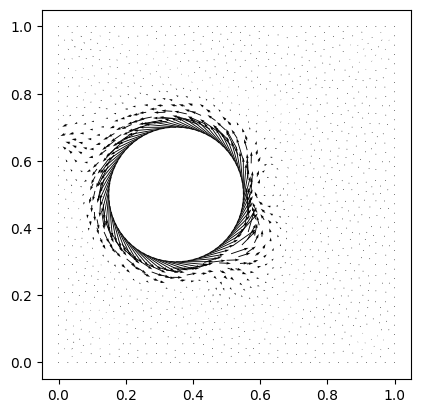

In [24]:

usol=u.at[unknown].set(res.x[:Nunknown])
vsol=v.at[unknown].set(res.x[Nunknown:2*Nunknown])
fig1, ax = plt.subplots(1,1, sharex=True, sharey=True)
ax.set_aspect('equal')
_=ax.quiver(verts[:,0],verts[:,1], usol, vsol, scale=2)

In [11]:
psol

Array([  59.6709,   49.0365,   39.0362, ...,  -12.9694,  -10.9404, -143.7827], dtype=float64)